In [1]:
import os
os.chdir(r"C:\git\jonie_github\MLDL\dacon\predict_apt_real_price\data")


# 학습 데이터 탐색 및 전처리
- 데이터셋 정보

```
1. train.csv : 서울/부산 지역의 1,100,000여개 거래 데이터, 아파트 거래일, 지역, 전용면적, 실 거래가 등의 정보
2. test.csv : 실 거래가를 제외하고 train.csv와 동일
3. park.csv : 서울/부산 지역의 공원에 대한 정보
4. day_care_center.csv : 서울/부산 지역의 어린이집에 대한 정보
```

In [2]:
import pandas as pd
#경고 출력 옵션 {"raise": 오류발생, "warn":경고출력(default), "None":무시}
pd.set_option('mode.chained_assignment', None)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
import missingno

import warnings
warnings.filterwarnings('ignore')

import sys
import os

In [3]:
matplotlib.rc('figure', figsize=(20,8))
matplotlib.rc('font', family="Malgun Gothinc", size=12)

In [4]:
train = pd.read_csv("train.csv", engine="python", encoding="utf-8")
train.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500
3,3,10957,서울특별시,내수동,95,파크팰리스,내수동 95 파크팰리스,146.39,2003,200801,11~20,15,118000
4,4,10639,서울특별시,내수동,110-15,킹스매너,내수동 110-15 킹스매너,194.43,2004,200801,21~31,3,120000


In [5]:
day_care_center_df = pd.read_csv("day_care_center.csv", engine="python", encoding="utf-8")
day_care_center_df.head()

,city,gu,day_care_name,day_care_type,day_care_baby_num,teacher_num,nursing_room_num,playground_num,CCTV_num,is_commuting_vehicle,reference_date
0,서울특별시,서대문구,가람어린이집,국공립,70,11.0,5.0,1.0,7.0,N,2018-07-31
1,서울특별시,서대문구,가좌제일어린이집,국공립,88,22.0,5.0,2.0,10.0,N,2018-07-31
2,서울특별시,서대문구,경찰청어린이집,직장,90,23.0,6.0,1.0,32.0,N,2018-07-31
3,서울특별시,서대문구,고운햇살어린이집,가정,18,5.0,3.0,0.0,4.0,N,2018-07-31
4,서울특별시,서대문구,고은어린이집,국공립,93,20.0,7.0,2.0,10.0,N,2018-07-31


In [6]:
park_df = pd.read_csv("park.csv", engine="python", encoding="utf-8")
park_df.head()

,city,gu,dong,park_name,park_type,park_area,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other,park_open_year,reference_date
0,부산광역시,남구,대연동,대연공원,근린공원,55227.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
1,부산광역시,남구,대연동,당곡공원,역사공원,75465.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
2,부산광역시,남구,대연동,대일어린이공원,어린이공원,422.1,NaN,NaN,NaN,NaN,NaN,1965.0,2018-08-14
3,부산광역시,남구,대연동,못골어린이공원,어린이공원,499.8,NaN,NaN,NaN,NaN,NaN,1968.0,2018-08-14
4,부산광역시,남구,용호동,솔밭어린이공원,어린이공원,1500.2,NaN,NaN,NaN,NaN,NaN,1970.0,2018-08-14


# train 데이터에 "구" 정보추가
-  행정구역의 정보가 있는 외부데이터를 train데이터에 추가한다.

외부데이터(excel) 형태

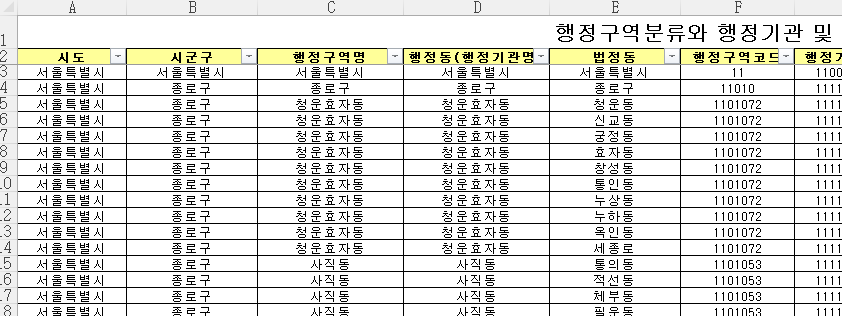

In [9]:
# !pip install openpyxl

In [7]:
ref_df = pd.read_excel("한국행정구역분류.xlsx", sheet_name="법정동코드 연계 자료분석용", header = 1) # 1번째 행에 있는 헤더는 제외하고 가져오기
ref_df.head()

,시도,시군구,행정구역명,행정동(행정기관명),법정동,행정구역코드,행정기관코드,행정기관 생성일,법정동코드,관할지역,행정동 영문명칭,비고
0,서울특별시,서울특별시,서울특별시,서울특별시,서울특별시,11.0,1100000000,19880423,1100000000,NaN,Seoul,NaN
1,서울특별시,종로구,종로구,종로구,종로구,11010.0,1111000000,19880423,1111000000,NaN,Jongno-gu,NaN
2,서울특별시,종로구,청운효자동,청운효자동,청운동,1101072.0,1111051500,20081101,1111010100,NaN,Cheongunhyoja-dong,NaN
3,서울특별시,종로구,청운효자동,청운효자동,신교동,1101072.0,1111051500,20081101,1111010200,NaN,Cheongunhyoja-dong,NaN
4,서울특별시,종로구,청운효자동,청운효자동,궁정동,1101072.0,1111051500,20081101,1111010300,NaN,Cheongunhyoja-dong,NaN


In [8]:
# 서울과 부산의 시도, 시군구, 법정동 데이터만
ref_df = ref_df.loc[(ref_df["시도"]=="서울특별시") | (ref_df["시도"]=="부산광역시"), ["시도", "시군구", "법정동"]]
ref_df.head()

,시도,시군구,법정동
0,서울특별시,서울특별시,서울특별시
1,서울특별시,종로구,종로구
2,서울특별시,종로구,청운동
3,서울특별시,종로구,신교동
4,서울특별시,종로구,궁정동


In [9]:
# 시도와 법정동을 기준으로 중복제거
ref_df = ref_df.drop_duplicates(subset=["시도", "법정동"])

In [10]:
# train 데이터와 일치하는지 확인
train_loc = (train["city"]  + "-" + train["dong"]).unique()
ref_df_loc = ref_df["시도"] + "-" + ref_df["법정동"] 
train_loc[~np.isin(train_loc, ref_df_loc)]

array(['부산광역시-기장읍 동부리', '부산광역시-기장읍 교리', '부산광역시-기장읍 서부리', '부산광역시-기장읍 대라리',
       '부산광역시-기장읍 청강리', '부산광역시-정관읍 달산리', '부산광역시-일광면 삼성리', '부산광역시-일광면 이천리',
       '부산광역시-기장읍 대변리', '부산광역시-정관읍 방곡리', '부산광역시-정관읍 용수리', '부산광역시-정관읍 매학리',
       '부산광역시-정관읍 모전리', '부산광역시-기장읍 내리', '부산광역시-철마면 고촌리', '부산광역시-장안읍 명례리',
       '부산광역시-장안읍 좌천리'], dtype=object)

In [11]:
train.dong.unique()[-10:]

array(['정관읍 모전리', '기장읍 내리', '철마면 고촌리', '장안읍 명례리', '장안읍 좌천리', '교남동', '효제동',
       '충무동1가', '대저1동', '녹산동'], dtype=object)

동이아니라 읍이나 면일경우 리 정보까지 들어가 있기 때문에 리는 제거하도록 함

In [12]:
train["dong"] = train["dong"].apply(lambda x: x.split()[0])
train.tail()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
1216548,1234823,9578,부산광역시,정관읍,1387,정관 동일스위트1차,정관읍 용수리 1387 정관 동일스위트1차,59.8245,2012,201711,11~20,3,22000
1216549,1234824,9578,부산광역시,정관읍,1387,정관 동일스위트1차,정관읍 용수리 1387 정관 동일스위트1차,84.9923,2012,201711,21~30,7,30750
1216550,1234825,9578,부산광역시,정관읍,1387,정관 동일스위트1차,정관읍 용수리 1387 정관 동일스위트1차,84.9923,2012,201711,21~30,9,29500
1216551,1234826,9586,부산광역시,정관읍,1364,정관신도시롯데캐슬,정관읍 용수리 1364 정관신도시롯데캐슬,101.7400,2008,201711,21~30,7,26700
1216552,1234827,9578,부산광역시,정관읍,1387,정관 동일스위트1차,정관읍 용수리 1387 정관 동일스위트1차,84.9923,2012,201711,21~30,16,28800


일치 여부 재확인

In [13]:
train_loc = (train["city"]  + "-" + train["dong"]).unique()
ref_df_loc = ref_df["시도"] + "-" + ref_df["법정동"] 
train_loc[~np.isin(train_loc, ref_df_loc)]

array([], dtype=object)

In [14]:
pd.merge(train, ref_df, left_on = ["city", "dong"], right_on=["시도", "법정동"]).head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,시도,시군구,법정동
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,서울특별시,종로구,신교동
1,98,7623,서울특별시,신교동,6-11,신현(102동),신교동 6-11 신현(102동),84.82,2002,200803,11~20,2,39300,서울특별시,종로구,신교동
2,511,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200903,21~31,3,40200,서울특별시,종로구,신교동
3,840,7623,서울특별시,신교동,6-11,신현(102동),신교동 6-11 신현(102동),81.02,2002,200909,1~10,1,42750,서울특별시,종로구,신교동
4,1201,7623,서울특별시,신교동,6-11,신현(102동),신교동 6-11 신현(102동),84.82,2002,201011,21~30,3,51700,서울특별시,종로구,신교동


In [15]:
train = pd.merge(train, ref_df, left_on = ["city", "dong"], right_on=["시도", "법정동"])
train.drop(["시도", "법정동"], axis=1, inplace=True)
train.rename(columns={"시군구":"sigungu"}, inplace=True)
train.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,sigungu
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,종로구
1,98,7623,서울특별시,신교동,6-11,신현(102동),신교동 6-11 신현(102동),84.82,2002,200803,11~20,2,39300,종로구
2,511,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200903,21~31,3,40200,종로구
3,840,7623,서울특별시,신교동,6-11,신현(102동),신교동 6-11 신현(102동),81.02,2002,200909,1~10,1,42750,종로구
4,1201,7623,서울특별시,신교동,6-11,신현(102동),신교동 6-11 신현(102동),84.82,2002,201011,21~30,3,51700,종로구


## feature 탐색
### 중복 feature 제거

In [16]:
# addr_kr = dong + jibun + apt = apartment_id(addr_kr를 id화 한 것으로 보임)
print(f"apartment_id_len:{len(train['apartment_id'].unique())}")
print(f"apt_len: {len(train['apt'].unique())}")
print(f"addr_kr_len: {len(train['addr_kr'].unique())}") # 제거

apartment_id_len:12533
apt_len: 10440
addr_kr_len: 12533


In [17]:
train[["apartment_id", "addr_kr"]].value_counts()

apartment_id  addr_kr             
8415          용호동 944 오륙도에스케이뷰        3220
10939         신천동 17 파크리오             3094
4449          다대동 1550 몰운대            2886
8031          미아동 1353 에스케이북한산시티      2572
2120          다대동 1624 다대동롯데캐슬몰운대     2536
                                      ... 
1800          방배동 804-3 나스빌(804-3)       1
7961          신사동 241 양지파크               1
1810          봉천동 1690-158 낙성대에메랄드       1
1815          구로동 791-22 낙원빌라            1
0             행당동 1-10 (1-10)            1
Length: 12533, dtype: int64

In [18]:
train.drop(['transaction_id', 'addr_kr', 'transaction_date'], axis = 1, inplace = True) # transaction_id는 인덱스와 동일하므로 삭제, 아파트를 사는데 일까지 고려하지는 않을것.

### transaction_year_month에서 year,month 분리




In [19]:
train["transaction_year"] = train["transaction_year_month"].apply(lambda x: str(x)[:4]).astype(int)
train["transaction_month"] = train["transaction_year_month"].apply(lambda x: str(x)[-2:]).astype(int)
train.head()

,apartment_id,city,dong,jibun,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,sigungu,transaction_year,transaction_month
0,7622,서울특별시,신교동,6-13,신현(101동),84.82,2002,200801,2,37500,종로구,2008,1
1,7623,서울특별시,신교동,6-11,신현(102동),84.82,2002,200803,2,39300,종로구,2008,3
2,7622,서울특별시,신교동,6-13,신현(101동),84.82,2002,200903,3,40200,종로구,2009,3
3,7623,서울특별시,신교동,6-11,신현(102동),81.02,2002,200909,1,42750,종로구,2009,9
4,7623,서울특별시,신교동,6-11,신현(102동),84.82,2002,201011,3,51700,종로구,2010,11


In [20]:
min(train.transaction_year_month)

200801

In [21]:
max(train.transaction_year_month)

201711

거래 년도를 기준으로 아파트가 지어진지 얼마되었는지

In [22]:
train["year_of_completion"].min()

1961

In [23]:
train["age"] = train["transaction_year"] - train["year_of_completion"]
train.head()

,apartment_id,city,dong,jibun,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,sigungu,transaction_year,transaction_month,age
0,7622,서울특별시,신교동,6-13,신현(101동),84.82,2002,200801,2,37500,종로구,2008,1,6
1,7623,서울특별시,신교동,6-11,신현(102동),84.82,2002,200803,2,39300,종로구,2008,3,6
2,7622,서울특별시,신교동,6-13,신현(101동),84.82,2002,200903,3,40200,종로구,2009,3,7
3,7623,서울특별시,신교동,6-11,신현(102동),81.02,2002,200909,1,42750,종로구,2009,9,7
4,7623,서울특별시,신교동,6-11,신현(102동),84.82,2002,201011,3,51700,종로구,2010,11,8


In [24]:
train[train["age"]<0]

,apartment_id,city,dong,jibun,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,sigungu,transaction_year,transaction_month,age
154851,6545,서울특별시,미아동,318-5,성북프라자,68.675,2009,200806,8,16000,강북구,2008,6,-1
154921,6545,서울특별시,미아동,318-5,성북프라자,68.675,2009,200808,8,17500,강북구,2008,8,-1
154948,6545,서울특별시,미아동,318-5,성북프라자,68.675,2009,200808,9,19000,강북구,2008,8,-1


### 서울, 부산을 0, 1로 변환

In [25]:
train["Seoul"] = (train["city"]=="서울특별시").astype("int64")
train.head()

,apartment_id,city,dong,jibun,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,sigungu,transaction_year,transaction_month,age,Seoul
0,7622,서울특별시,신교동,6-13,신현(101동),84.82,2002,200801,2,37500,종로구,2008,1,6,1
1,7623,서울특별시,신교동,6-11,신현(102동),84.82,2002,200803,2,39300,종로구,2008,3,6,1
2,7622,서울특별시,신교동,6-13,신현(101동),84.82,2002,200903,3,40200,종로구,2009,3,7,1
3,7623,서울특별시,신교동,6-11,신현(102동),81.02,2002,200909,1,42750,종로구,2009,9,7,1
4,7623,서울특별시,신교동,6-11,신현(102동),84.82,2002,201011,3,51700,종로구,2010,11,8,1


### floor는 연속형 변수? 범주형 변수?
- 층별로 가격 차이가 있는지 확인

<AxesSubplot:xlabel='floor'>

findfont: Font family ['Malgun Gothinc'] not found. Falling back to DejaVu Sans.


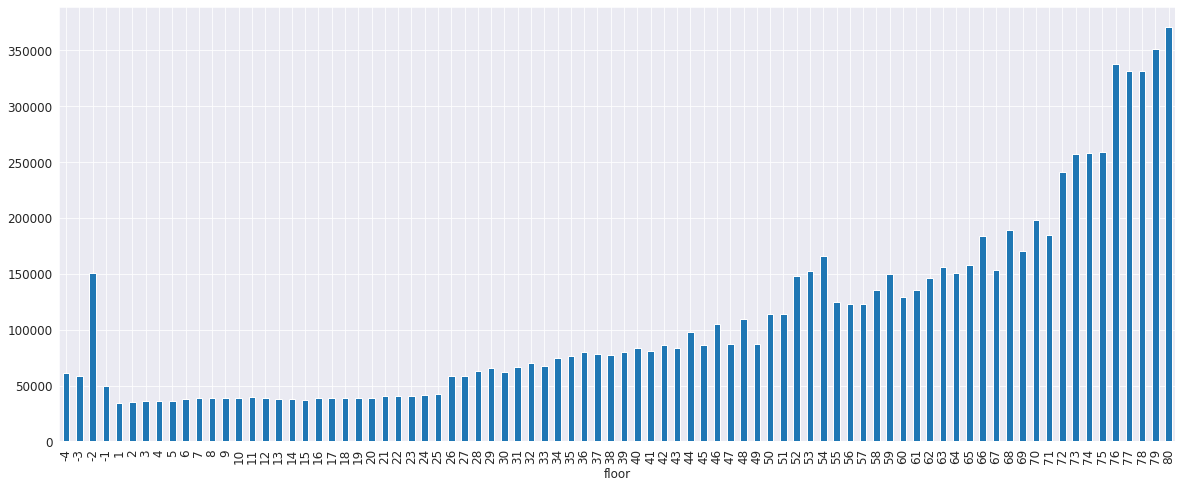

In [26]:
train.groupby("floor")["transaction_real_price"].mean().plot(kind="bar")

층 별로 가격차이가 나는 구간이 있는 것으로 보임.
`15,16사이, 25~26 사이, 51~52 사이, 71~72사이 구간`

In [27]:
# 층변수 범주화
def convert_floor_level(x):
    if x < 16:
        return "저층"
    elif x < 26:
        return "중저층"
    elif x < 52:
        return "중층"
    elif x < 71:
        return "고층"
    else:
        return "초고층"

In [28]:
train["floor_level"] = train["floor"].apply(lambda x: convert_floor_level(x))
train.head()

,apartment_id,city,dong,jibun,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,sigungu,transaction_year,transaction_month,age,Seoul,floor_level
0,7622,서울특별시,신교동,6-13,신현(101동),84.82,2002,200801,2,37500,종로구,2008,1,6,1,저층
1,7623,서울특별시,신교동,6-11,신현(102동),84.82,2002,200803,2,39300,종로구,2008,3,6,1,저층
2,7622,서울특별시,신교동,6-13,신현(101동),84.82,2002,200903,3,40200,종로구,2009,3,7,1,저층
3,7623,서울특별시,신교동,6-11,신현(102동),81.02,2002,200909,1,42750,종로구,2009,9,7,1,저층
4,7623,서울특별시,신교동,6-11,신현(102동),84.82,2002,201011,3,51700,종로구,2010,11,8,1,저층


범주화가 잘 되었는지 시각화를 통해 확인

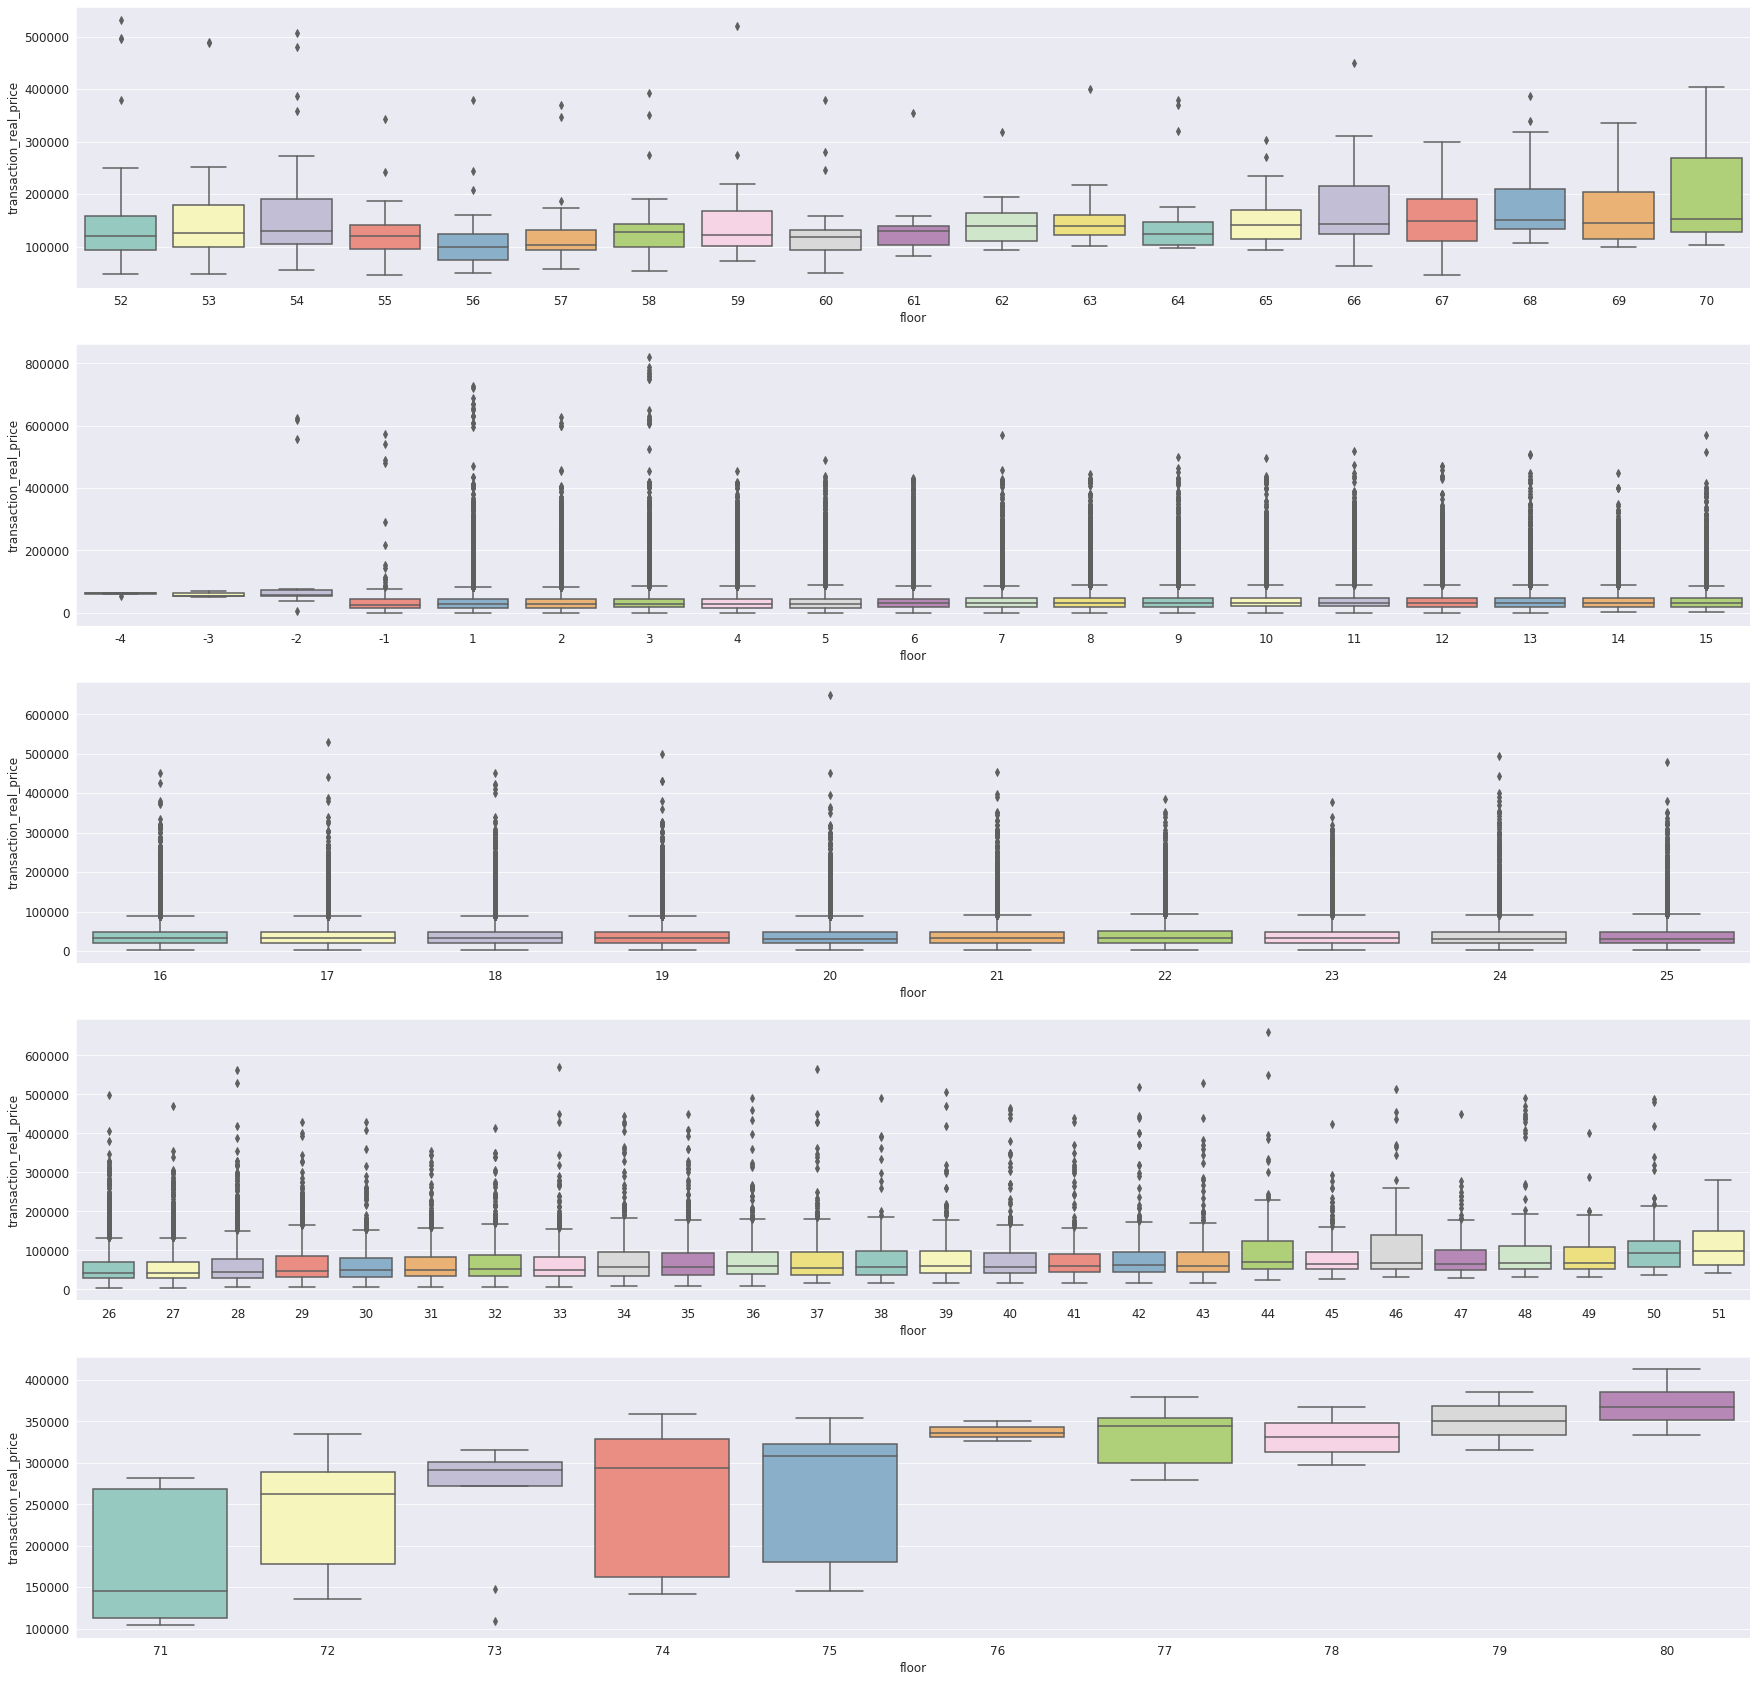

In [29]:
f, ax = plt.subplots(len(train["floor_level"].unique()),1, figsize=(30, 30))
for i, col in enumerate(sorted(train["floor_level"].unique())):
    sns.boxplot(data=train[train["floor_level"] == col], x="floor", y="transaction_real_price", ax=ax[i], palette="Set3")

```
결론: floor_level 변수는 유의하나, floor 변수는 초고층에서만 유의
고층-초고층으로 세분화하거나, floor_level 변수와 floor 변수를 같이 사용하고 교호작용을 고려할 수 있는 트리 계열의 모델 사용이 적합
```

### 구별 전체 평균 시세 변수 추가

In [30]:
mean_price_per_gu = train.groupby(["city", "sigungu"])["transaction_real_price"].mean().rename("mean_price_per_gu").reset_index()
train = pd.merge(train, mean_price_per_gu, on = ["city", "sigungu"])
train.head()

,apartment_id,city,dong,jibun,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,sigungu,transaction_year,transaction_month,age,Seoul,floor_level,mean_price_per_gu
0,7622,서울특별시,신교동,6-13,신현(101동),84.82,2002,200801,2,37500,종로구,2008,1,6,1,저층,48968.885914
1,7623,서울특별시,신교동,6-11,신현(102동),84.82,2002,200803,2,39300,종로구,2008,3,6,1,저층,48968.885914
2,7622,서울특별시,신교동,6-13,신현(101동),84.82,2002,200903,3,40200,종로구,2009,3,7,1,저층,48968.885914
3,7623,서울특별시,신교동,6-11,신현(102동),81.02,2002,200909,1,42750,종로구,2009,9,7,1,저층,48968.885914
4,7623,서울특별시,신교동,6-11,신현(102동),84.82,2002,201011,3,51700,종로구,2010,11,8,1,저층,48968.885914


In [31]:
# 구별 작년 시세 변수 추가 - 거래량이 없을 경우 가격 어떻게 처리할지.
price_per_gu_last_year = train.copy().groupby(["city", "sigungu", "transaction_year"])["transaction_real_price"].agg(["mean", "count"]).reset_index()
price_per_gu_last_year.rename({"mean":"mean_price_per_gu_last_year", "count":"volumn_per_gu_last_year"}, axis=1, inplace=True)

price_per_gu_last_year["transaction_year"] += 1     # 작년 데이터를 붙이기 위해 더함
train = pd.merge(train, price_per_gu_last_year, on = ["city", "sigungu", "transaction_year"], how="left") # 작년 기록이 없을 경우 원본 보존
train["volumn_per_gu_last_year"].fillna(0, inplace=True)    # 거래량이 없을 경우 0
train.head()

,apartment_id,city,dong,jibun,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,sigungu,transaction_year,transaction_month,age,Seoul,floor_level,mean_price_per_gu,mean_price_per_gu_last_year,volumn_per_gu_last_year
0,7622,서울특별시,신교동,6-13,신현(101동),84.82,2002,200801,2,37500,종로구,2008,1,6,1,저층,48968.885914,NaN,0.0
1,7623,서울특별시,신교동,6-11,신현(102동),84.82,2002,200803,2,39300,종로구,2008,3,6,1,저층,48968.885914,NaN,0.0
2,7622,서울특별시,신교동,6-13,신현(101동),84.82,2002,200903,3,40200,종로구,2009,3,7,1,저층,48968.885914,37679.711752,451.0
3,7623,서울특별시,신교동,6-11,신현(102동),81.02,2002,200909,1,42750,종로구,2009,9,7,1,저층,48968.885914,37679.711752,451.0
4,7623,서울특별시,신교동,6-11,신현(102동),84.82,2002,201011,3,51700,종로구,2010,11,8,1,저층,48968.885914,45436.050584,514.0


### 공원 데이터 병합


In [32]:
park_df.head()

,city,gu,dong,park_name,park_type,park_area,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other,park_open_year,reference_date
0,부산광역시,남구,대연동,대연공원,근린공원,55227.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
1,부산광역시,남구,대연동,당곡공원,역사공원,75465.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
2,부산광역시,남구,대연동,대일어린이공원,어린이공원,422.1,NaN,NaN,NaN,NaN,NaN,1965.0,2018-08-14
3,부산광역시,남구,대연동,못골어린이공원,어린이공원,499.8,NaN,NaN,NaN,NaN,NaN,1968.0,2018-08-14
4,부산광역시,남구,용호동,솔밭어린이공원,어린이공원,1500.2,NaN,NaN,NaN,NaN,NaN,1970.0,2018-08-14


In [33]:
day_care_center_df.head()

,city,gu,day_care_name,day_care_type,day_care_baby_num,teacher_num,nursing_room_num,playground_num,CCTV_num,is_commuting_vehicle,reference_date
0,서울특별시,서대문구,가람어린이집,국공립,70,11.0,5.0,1.0,7.0,N,2018-07-31
1,서울특별시,서대문구,가좌제일어린이집,국공립,88,22.0,5.0,2.0,10.0,N,2018-07-31
2,서울특별시,서대문구,경찰청어린이집,직장,90,23.0,6.0,1.0,32.0,N,2018-07-31
3,서울특별시,서대문구,고운햇살어린이집,가정,18,5.0,3.0,0.0,4.0,N,2018-07-31
4,서울특별시,서대문구,고은어린이집,국공립,93,20.0,7.0,2.0,10.0,N,2018-07-31


<AxesSubplot:>

findfont: Font family ['Malgun Gothinc'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothinc'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothinc'] not found. Falling back to DejaVu Sans.


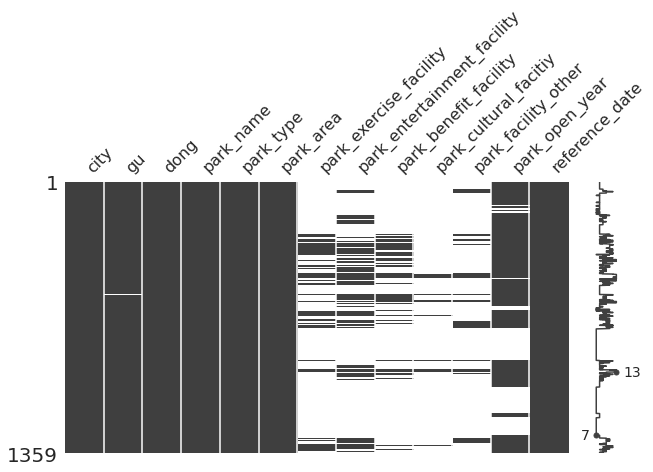

In [34]:
missingno.matrix(park_df, figsize=(10,5))

### 결측치 처리

In [35]:
park_df[park_df["gu"].isna()]

,city,gu,dong,park_name,park_type,park_area,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other,park_open_year,reference_date
565,부산광역시,NaN,영주동,중앙공원,근린공원,5020657.0,"""운동광장, 게이트볼, 궁도장, 구민운동장, 풋살경기장, 다목적 마당, 인라인스케이...","""어린이놀이터, 발물놀이터""","""주차장,화장실, 대중음식점,매점,전망대,다과점,치유센터,숲속요가장및 풍욕장, 낙상...","""도서관, 기념비, 충혼탑, 장건상동상, 대한해협전승비, 자연보호헌장, 시민헌장, ...","""도로, 광장, 파고라, 못, 생태연못, 야영장, 음수대, 휴게소, 야유회장, 전망...",1986.0,2018-08-01
566,부산광역시,NaN,초읍동,어린이대공원,근린공원,4947290.0,"""골프연습장, 배드민턴장""","""케이블카, 어린이유희시설, 가족유희시설, 짚라인""","""제1주차장, 전망대, 매점, 매점(기념품), 휴게음식점, 간이화장실, 공중화장실...","""동물원시설, 어린이회관, 학생수련회야영장, 반공전시관, 전시관, 위인탑, 교육문화...","""경로당, 야영장, 힐링데크, 트리하우스, 스카이워크, 산림욕장, 관리사무소, 안내...",1978.0,2018-08-01
567,부산광역시,NaN,온천동,금강공원,근린공원,3096579.0,"""배트민턴, 궁도장""","""유희시설, 삭도, 어드벤처, 숲속어드벤처""","""공중화장실, 유스호스텔, 전망대, 주차장""","""해양자연사박물관, 도서관, 민속예술관, 고분, 기념비및사적, 소방안전체험관, 박물...","""도로, 광장, 못, 케스케이드, 미로공원, 녹차체험장, 암석원, 야영장, 힐링캠프...",1965.0,2018-08-01


In [36]:
ref_df.loc[ref_df["법정동"].isin(["영주동","초읍동","온천동"]), ["시군구", "법정동"]]

,시군구,법정동
805,중구,영주동
884,부산진구,초읍동
909,동래구,온천동


In [37]:
park_df.iloc[565,1] = "중구"
park_df.iloc[566,1] = "부산진구"
park_df.iloc[567,1] = "동래구"
park_df.iloc[565:568,1]

565      중구
566    부산진구
567     동래구
Name: gu, dtype: object

gu는 excel데이터를 이용하여 채우고, park_exercise_facility	park_entertainment_facility	park_benefit_facility	park_cultural_facitiy	park_facility_other는 종류가 너무 많기 때문에 시설의 유무로 나타내기로 함


In [38]:
park_df.rename({"park_cultural_facitiy": "park_cultural_facility"}, axis=1,inplace=True)

In [39]:
facility_cols = [x for x in park_df.columns if "facility" in x]
facility_cols

['park_exercise_facility',
 'park_entertainment_facility',
 'park_benefit_facility',
 'park_cultural_facility',
 'park_facility_other']

<AxesSubplot:>

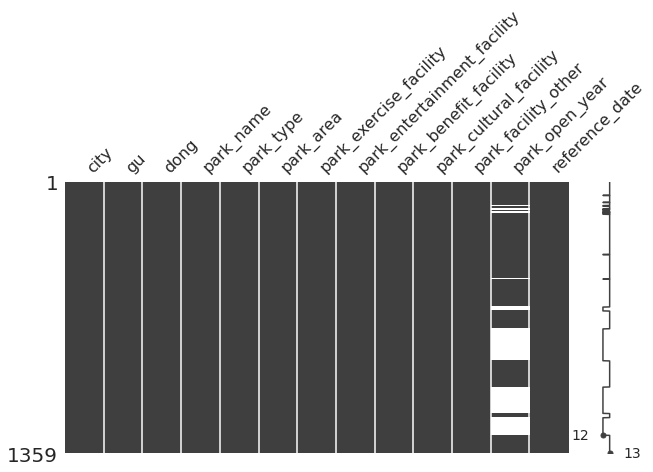

In [40]:
for col in facility_cols:
    park_df.loc[park_df[col].isna()==False, col] = 1
    park_df.loc[park_df[col].isna(), col] = 0
missingno.matrix(park_df, figsize=(10,5))

In [41]:
# 동별 공원 수 
num_park_per_dong = park_df.groupby(['city', 'gu', 'dong'], as_index=False)['park_name'].count()
num_park_per_dong.rename({"park_name":"num_of_park"}, axis = 1, inplace = True)
num_park_per_dong.head()

,city,gu,dong,num_of_park
0,부산광역시,강서구,녹산동,1
1,부산광역시,강서구,대저1동,1
2,부산광역시,강서구,명지동,25
3,부산광역시,강서구,송정동,2
4,부산광역시,강서구,신호동,4


In [42]:
# 동별 공원에 배치된 facilty 수
num_facilty_per_dong = park_df.groupby(['city', 'gu', 'dong'], as_index=False)[facility_cols].sum()
num_facilty_per_dong.head()

,city,gu,dong,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facility,park_facility_other
0,부산광역시,강서구,녹산동,1,0,1,0,1
1,부산광역시,강서구,대저1동,1,0,0,0,1
2,부산광역시,강서구,명지동,13,17,4,0,25
3,부산광역시,강서구,송정동,2,0,2,0,2
4,부산광역시,강서구,신호동,2,3,1,0,3


In [43]:
train = pd.merge(train, num_park_per_dong, left_on = ['city', 'sigungu', 'dong'], right_on = ['city', 'gu', 'dong'], how = 'left')
train['num_of_park'].fillna(0, inplace = True)
train.drop('gu', axis = 1, inplace = True)
    
train = pd.merge(train, num_facilty_per_dong, left_on = ['city', 'sigungu', 'dong'], right_on = ['city', 'gu', 'dong'], how = 'left')
train.drop('gu', axis = 1, inplace = True)

In [44]:
facility_cols

['park_exercise_facility',
 'park_entertainment_facility',
 'park_benefit_facility',
 'park_cultural_facility',
 'park_facility_other']

In [45]:
for col in facility_cols:
    train[col].fillna(0, inplace = True)

<AxesSubplot:>

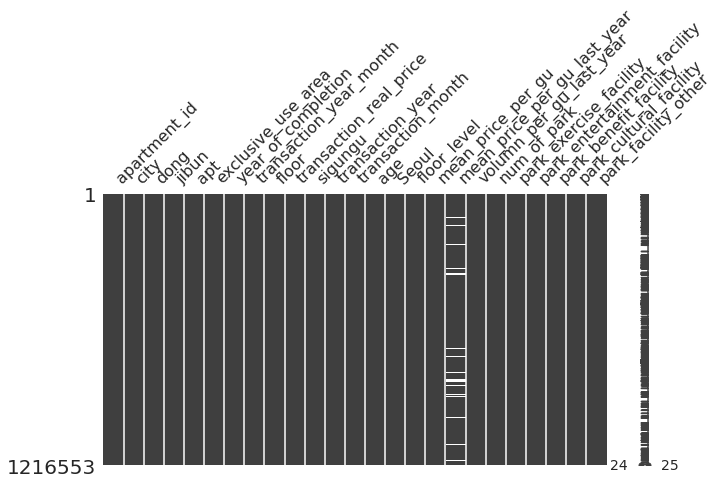

In [46]:
missingno.matrix(train, figsize=(10,5))

### 어린이집 데이터

<AxesSubplot:>

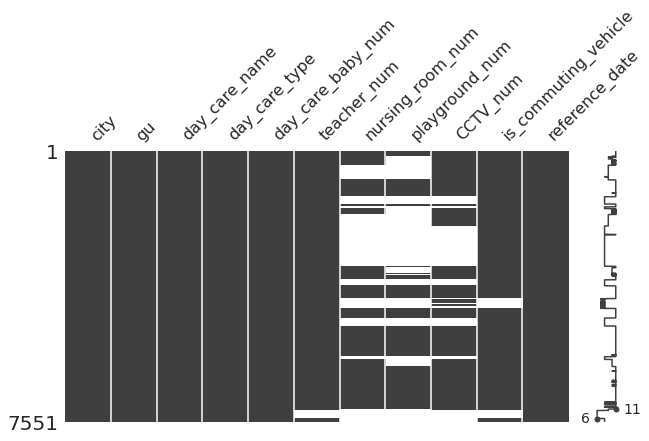

In [47]:
missingno.matrix(day_care_center_df, figsize=(10,5))

결측치 처리: 어린이 집을 고려할 때 국공립/사립이나 정원은 고려해도 결측치가 발생한 열까지는 고려할것 같지 않다. drop

In [48]:
day_care_center_df.columns

Index(['city', 'gu', 'day_care_name', 'day_care_type', 'day_care_baby_num',
       'teacher_num', 'nursing_room_num', 'playground_num', 'CCTV_num',
       'is_commuting_vehicle', 'reference_date'],
      dtype='object')

In [49]:
# 불필요한 변수 제거
day_care_center_df = day_care_center_df[['city', 'gu', 'day_care_type', 'day_care_baby_num']]

In [50]:
from sklearn.preprocessing import LabelEncoder
day_care_type_le = LabelEncoder()
day_care_center_df["day_care_type"] = day_care_type_le.fit_transform(day_care_center_df["day_care_type"])
day_care_center_df["day_care_type"]

0       1
1       1
2       5
3       0
4       1
       ..
7546    2
7547    0
7548    2
7549    2
7550    2
Name: day_care_type, Length: 7551, dtype: int32

In [51]:
dict(zip(day_care_type_le.classes_, day_care_type_le.transform(day_care_type_le.classes_)))

{'가정': 0, '국공립': 1, '민간': 2, '법인·단체': 3, '사회복지법인': 4, '직장': 5, '협동': 6}

In [52]:
dummy_day_care_type = pd.get_dummies(day_care_center_df['day_care_type'], drop_first = False)
dummy_day_care_type = dummy_day_care_type.add_prefix("day_care_type_")

day_care_center_df = pd.concat([day_care_center_df, dummy_day_care_type], axis = 1)
day_care_center_df.drop('day_care_type', axis = 1, inplace = True)
day_care_center_df.head()

,city,gu,day_care_baby_num,day_care_type_0,day_care_type_1,day_care_type_2,day_care_type_3,day_care_type_4,day_care_type_5,day_care_type_6
0,서울특별시,서대문구,70,0,1,0,0,0,0,0
1,서울특별시,서대문구,88,0,1,0,0,0,0,0
2,서울특별시,서대문구,90,0,0,0,0,0,1,0
3,서울특별시,서대문구,18,1,0,0,0,0,0,0
4,서울특별시,서대문구,93,0,1,0,0,0,0,0


In [53]:
aggregated_day_care_center_df = day_care_center_df.groupby(['city', 'gu'], as_index = False)[day_care_center_df.columns[2:]].sum()
aggregated_day_care_center_df.head()

,city,gu,day_care_baby_num,day_care_type_0,day_care_type_1,day_care_type_2,day_care_type_3,day_care_type_4,day_care_type_5,day_care_type_6
0,부산광역시,강서구,5312,71.0,6.0,35.0,0.0,5.0,5.0,1.0
1,부산광역시,금정구,5251,30.0,6.0,58.0,1.0,7.0,3.0,1.0
2,부산광역시,기장군,7689,98.0,13.0,56.0,0.0,5.0,3.0,3.0
3,부산광역시,남구,6676,65.0,12.0,50.0,2.0,6.0,6.0,2.0
4,부산광역시,동구,2214,8.0,9.0,11.0,2.0,2.0,7.0,0.0


In [54]:
train = pd.merge(train, aggregated_day_care_center_df, left_on = ['city', 'sigungu'], right_on = ['city', 'gu'], how = 'left')
train[aggregated_day_care_center_df.columns].fillna(0, inplace = True)
train.drop('gu', axis = 1, inplace = True)
train.head()

,apartment_id,city,dong,jibun,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,...,park_cultural_facility,park_facility_other,day_care_baby_num,day_care_type_0,day_care_type_1,day_care_type_2,day_care_type_3,day_care_type_4,day_care_type_5,day_care_type_6
0,7622,서울특별시,신교동,6-13,신현(101동),84.82,2002,200801,2,37500,...,0.0,0.0,4902.0,4.0,33.0,9.0,3.0,2.0,27.0,0.0
1,7623,서울특별시,신교동,6-11,신현(102동),84.82,2002,200803,2,39300,...,0.0,0.0,4902.0,4.0,33.0,9.0,3.0,2.0,27.0,0.0
2,7622,서울특별시,신교동,6-13,신현(101동),84.82,2002,200903,3,40200,...,0.0,0.0,4902.0,4.0,33.0,9.0,3.0,2.0,27.0,0.0
3,7623,서울특별시,신교동,6-11,신현(102동),81.02,2002,200909,1,42750,...,0.0,0.0,4902.0,4.0,33.0,9.0,3.0,2.0,27.0,0.0
4,7623,서울특별시,신교동,6-11,신현(102동),84.82,2002,201011,3,51700,...,0.0,0.0,4902.0,4.0,33.0,9.0,3.0,2.0,27.0,0.0


### 필요없는 특징 제거 및 더미화, 정규화
- 동에 따라 아파트가격의 차이가 있으므로 남겨둠

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216553 entries, 0 to 1216552
Data columns (total 33 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   apartment_id                 1216553 non-null  int64  
 1   city                         1216553 non-null  object 
 2   dong                         1216553 non-null  object 
 3   jibun                        1216553 non-null  object 
 4   apt                          1216553 non-null  object 
 5   exclusive_use_area           1216553 non-null  float64
 6   year_of_completion           1216553 non-null  int64  
 7   transaction_year_month       1216553 non-null  int64  
 8   floor                        1216553 non-null  int64  
 9   transaction_real_price       1216553 non-null  int64  
 10  sigungu                      1216553 non-null  object 
 11  transaction_year             1216553 non-null  int32  
 12  transaction_month            1216553 non-n

In [56]:
train =  train.drop(['apartment_id', 'city', 'jibun', 'apt', 'sigungu', 'transaction_year_month', 'transaction_month'], axis = 1)

string데이터 변경

In [57]:
dong_le = LabelEncoder()
dong_le.fit(train["dong"])
train["dong"] = dong_le.transform(train["dong"])

결측치는 드랍하거나 채워넣기:채워넣기로

<AxesSubplot:>

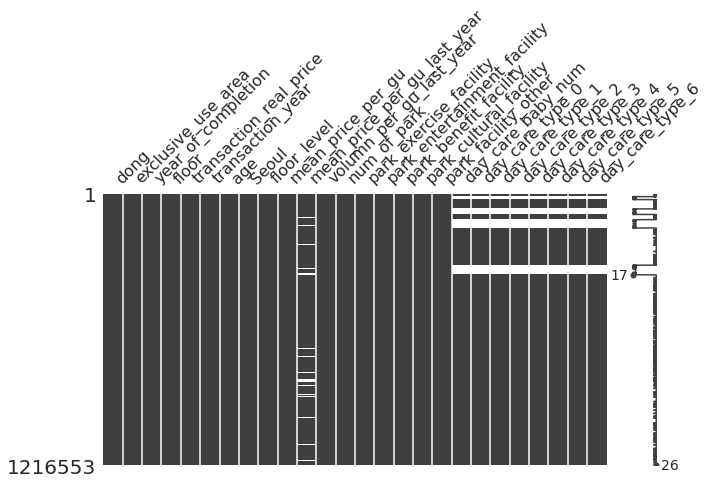

In [58]:
missingno.matrix(train, figsize=(10,5))

In [59]:
train_dropna = train.dropna(axis=0).reset_index(drop=True)
train_dropna

,dong,exclusive_use_area,year_of_completion,floor,transaction_real_price,transaction_year,age,Seoul,floor_level,mean_price_per_gu,...,park_cultural_facility,park_facility_other,day_care_baby_num,day_care_type_0,day_care_type_1,day_care_type_2,day_care_type_3,day_care_type_4,day_care_type_5,day_care_type_6
0,251,84.82,2002,3,40200,2009,7,1,저층,48968.885914,...,0.0,0.0,4902.0,4.0,33.0,9.0,3.0,2.0,27.0,0.0
1,251,81.02,2002,1,42750,2009,7,1,저층,48968.885914,...,0.0,0.0,4902.0,4.0,33.0,9.0,3.0,2.0,27.0,0.0
2,251,84.82,2002,3,51700,2010,8,1,저층,48968.885914,...,0.0,0.0,4902.0,4.0,33.0,9.0,3.0,2.0,27.0,0.0
3,251,84.82,2002,4,53500,2011,9,1,저층,48968.885914,...,0.0,0.0,4902.0,4.0,33.0,9.0,3.0,2.0,27.0,0.0
4,251,84.82,2002,3,50000,2013,11,1,저층,48968.885914,...,0.0,0.0,4902.0,4.0,33.0,9.0,3.0,2.0,27.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006440,361,60.56,2016,5,17100,2016,0,0,저층,19655.473365,...,0.0,0.0,7689.0,98.0,13.0,56.0,0.0,5.0,3.0,3.0
1006441,361,62.44,2016,3,18300,2016,0,0,저층,19655.473365,...,0.0,0.0,7689.0,98.0,13.0,56.0,0.0,5.0,3.0,3.0
1006442,361,62.44,2016,5,18600,2017,1,0,저층,19655.473365,...,0.0,0.0,7689.0,98.0,13.0,56.0,0.0,5.0,3.0,3.0
1006443,361,63.78,2016,2,17800,2017,1,0,저층,19655.473365,...,0.0,0.0,7689.0,98.0,13.0,56.0,0.0,5.0,3.0,3.0


In [60]:
train_dropna.columns

Index(['dong', 'exclusive_use_area', 'year_of_completion', 'floor',
       'transaction_real_price', 'transaction_year', 'age', 'Seoul',
       'floor_level', 'mean_price_per_gu', 'mean_price_per_gu_last_year',
       'volumn_per_gu_last_year', 'num_of_park', 'park_exercise_facility',
       'park_entertainment_facility', 'park_benefit_facility',
       'park_cultural_facility', 'park_facility_other', 'day_care_baby_num',
       'day_care_type_0', 'day_care_type_1', 'day_care_type_2',
       'day_care_type_3', 'day_care_type_4', 'day_care_type_5',
       'day_care_type_6'],
      dtype='object')

In [61]:
for col in ['num_of_park',
       'park_exercise_facility', 'park_entertainment_facility',
       'park_benefit_facility', 'park_cultural_facility',
       'park_facility_other', 'day_care_baby_num', 'day_care_type_0',
       'day_care_type_1', 'day_care_type_2', 'day_care_type_3',
       'day_care_type_4', 'day_care_type_5', 'day_care_type_6']:
    train_dropna[col] = train_dropna[col].astype("int64")
train_dropna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006445 entries, 0 to 1006444
Data columns (total 26 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   dong                         1006445 non-null  int32  
 1   exclusive_use_area           1006445 non-null  float64
 2   year_of_completion           1006445 non-null  int64  
 3   floor                        1006445 non-null  int64  
 4   transaction_real_price       1006445 non-null  int64  
 5   transaction_year             1006445 non-null  int32  
 6   age                          1006445 non-null  int64  
 7   Seoul                        1006445 non-null  int64  
 8   floor_level                  1006445 non-null  object 
 9   mean_price_per_gu            1006445 non-null  float64
 10  mean_price_per_gu_last_year  1006445 non-null  float64
 11  volumn_per_gu_last_year      1006445 non-null  float64
 12  num_of_park                  1006445 non-n

In [62]:
num_cols = list(train_dropna.select_dtypes(include=np.number).columns)
num_cols

['dong',
 'exclusive_use_area',
 'year_of_completion',
 'floor',
 'transaction_real_price',
 'transaction_year',
 'age',
 'Seoul',
 'mean_price_per_gu',
 'mean_price_per_gu_last_year',
 'volumn_per_gu_last_year',
 'num_of_park',
 'park_exercise_facility',
 'park_entertainment_facility',
 'park_benefit_facility',
 'park_cultural_facility',
 'park_facility_other',
 'day_care_baby_num',
 'day_care_type_0',
 'day_care_type_1',
 'day_care_type_2',
 'day_care_type_3',
 'day_care_type_4',
 'day_care_type_5',
 'day_care_type_6']

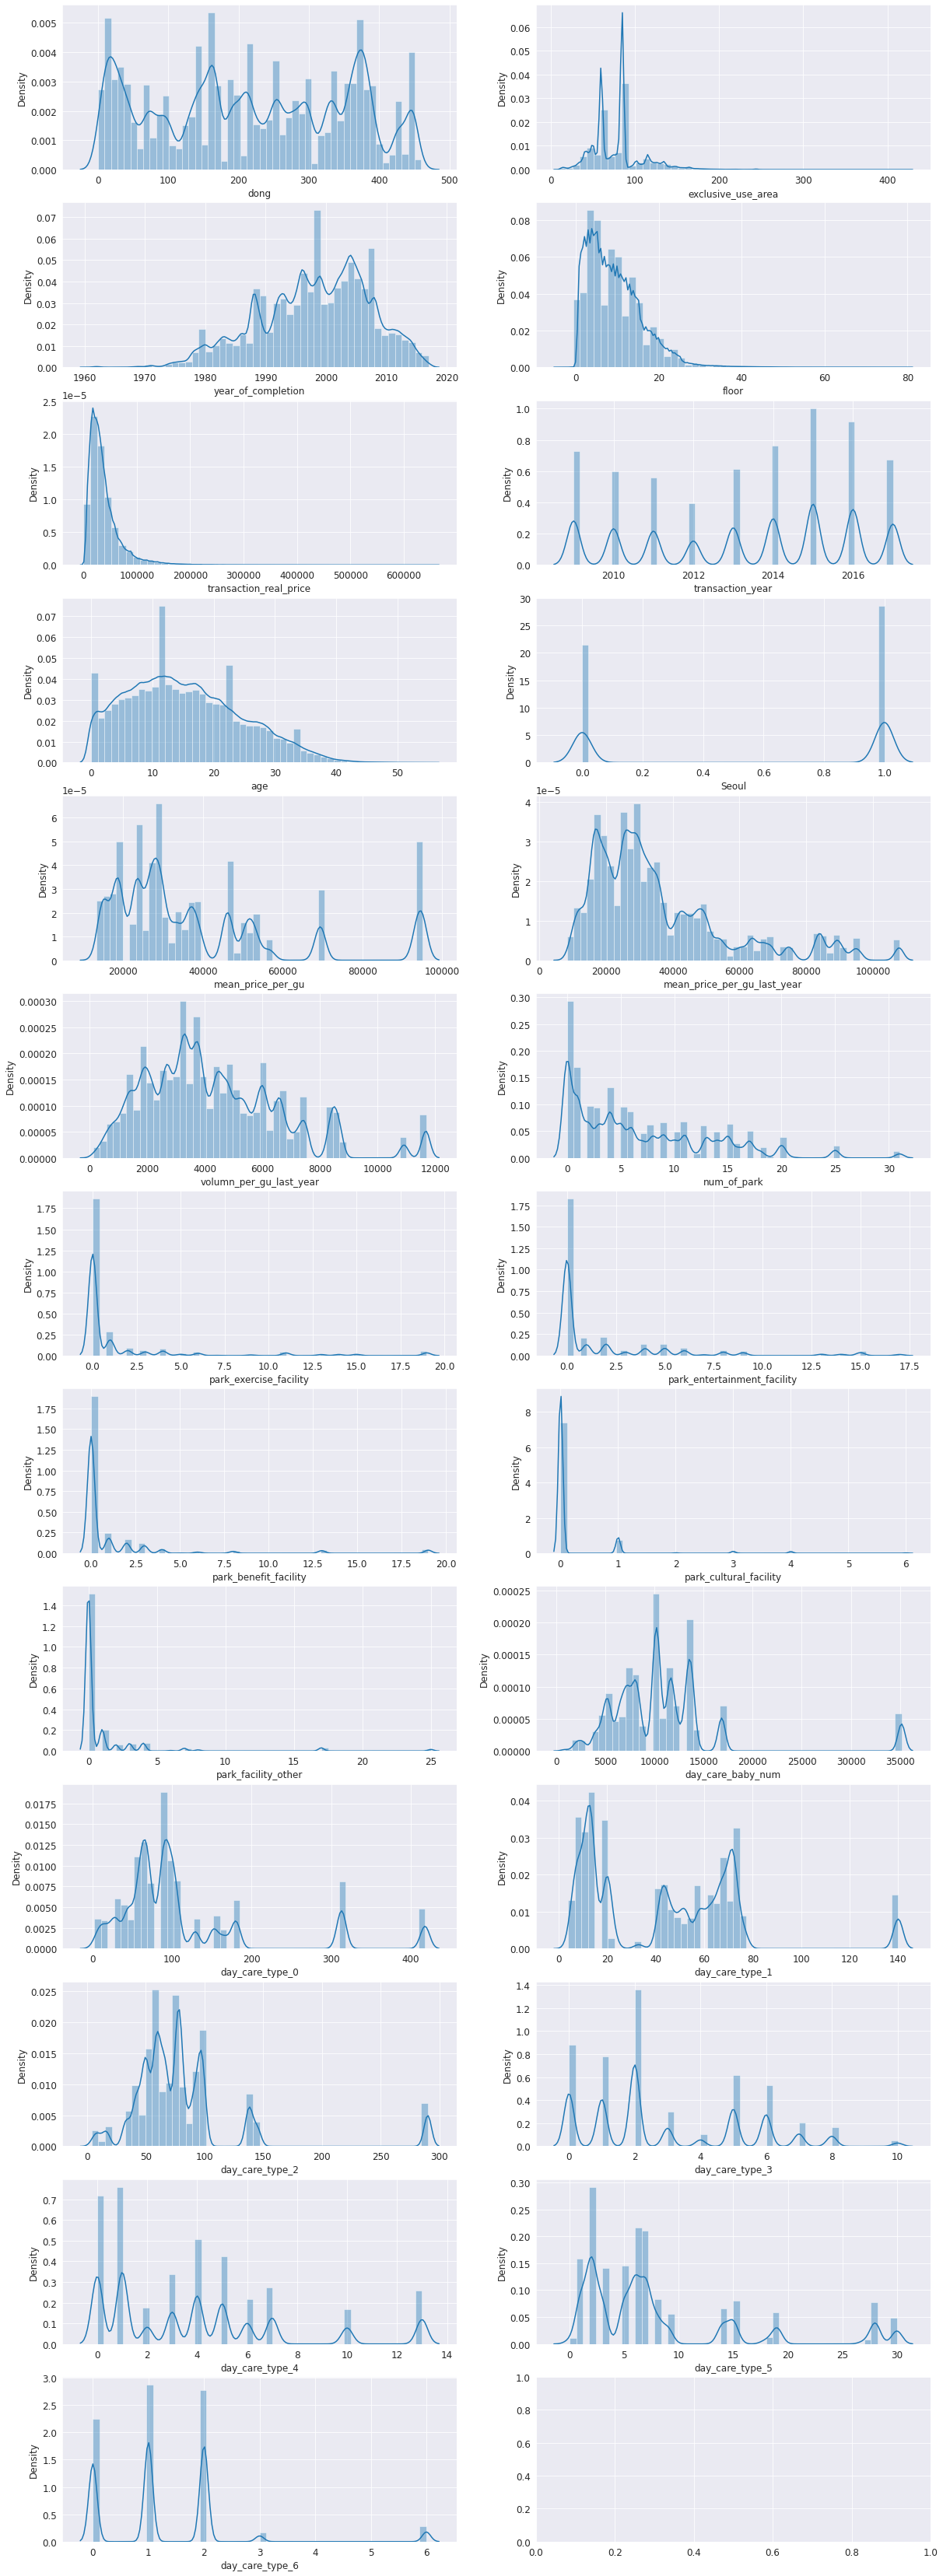

In [63]:
import math
f, ax = plt.subplots(math.ceil(len(num_cols)/2), 2, figsize=(20,60))
for i, col in enumerate(num_cols):
    sns.distplot(train_dropna[col], ax=ax[i//2][i%2], kde=True)
plt.show()

### 왜도 및 첨도 확인

In [64]:
from scipy.stats import *
for col in num_cols:
    if abs(skew(train_dropna[col])) >= 1.5:
        print(f"[{col}] skew : {skew(train_dropna[col])}")
    if abs(kurtosis(train_dropna[col])) >= 3:
        print(f"[{col}] kurtosis : {kurtosis(train_dropna[col])}")

[floor] kurtosis : 4.186270019984383
[transaction_real_price] skew : 3.103813456057421
[transaction_real_price] kurtosis : 17.83754256787741
[park_exercise_facility] skew : 3.2915069946979907
[park_exercise_facility] kurtosis : 10.614146385498088
[park_entertainment_facility] skew : 2.380938559055364
[park_entertainment_facility] kurtosis : 5.559248242795762
[park_benefit_facility] skew : 4.1485830841765345
[park_benefit_facility] kurtosis : 18.048278536188086
[park_cultural_facility] skew : 5.048142862398188
[park_cultural_facility] kurtosis : 30.385893943293297
[park_facility_other] skew : 5.279971874407783
[park_facility_other] kurtosis : 31.345469918287932
[day_care_baby_num] skew : 2.523299349888013
[day_care_baby_num] kurtosis : 8.246039407220005
[day_care_type_0] skew : 1.9423329519259402
[day_care_type_0] kurtosis : 3.231874196602469
[day_care_type_2] skew : 2.7194106930798525
[day_care_type_2] kurtosis : 8.820393920433654
[day_care_type_5] skew : 1.627563641731844
[day_care_ty

로그변환 정규화

In [65]:
numeric_cols = list(train_dropna.select_dtypes(include="float64").columns) + ["transaction_real_price"]

In [66]:
for col in numeric_cols:
    train_dropna["log_"+col] = np.log1p(train_dropna[col])
    train["log_"+col] = np.log1p(train[col])

In [67]:
train.columns

Index(['dong', 'exclusive_use_area', 'year_of_completion', 'floor',
       'transaction_real_price', 'transaction_year', 'age', 'Seoul',
       'floor_level', 'mean_price_per_gu', 'mean_price_per_gu_last_year',
       'volumn_per_gu_last_year', 'num_of_park', 'park_exercise_facility',
       'park_entertainment_facility', 'park_benefit_facility',
       'park_cultural_facility', 'park_facility_other', 'day_care_baby_num',
       'day_care_type_0', 'day_care_type_1', 'day_care_type_2',
       'day_care_type_3', 'day_care_type_4', 'day_care_type_5',
       'day_care_type_6', 'log_exclusive_use_area', 'log_mean_price_per_gu',
       'log_mean_price_per_gu_last_year', 'log_volumn_per_gu_last_year',
       'log_transaction_real_price'],
      dtype='object')

In [69]:
!pip install feature_engine

In [78]:
# floor_level 더미화
from feature_engine.encoding import OneHotEncoder as OHE
dummy_model = OHE(variables = ["floor_level"], drop_last = True)
train = dummy_model.fit_transform(train)
train

,dong,exclusive_use_area,year_of_completion,floor,transaction_real_price,transaction_year,age,Seoul,mean_price_per_gu,mean_price_per_gu_last_year,...,day_care_type_6,log_exclusive_use_area,log_mean_price_per_gu,log_mean_price_per_gu_last_year,log_volumn_per_gu_last_year,log_transaction_real_price,floor_level_저층,floor_level_중저층,floor_level_중층,floor_level_고층
0,251,84.82,2002,2,37500,2008,6,1,48968.885914,NaN,...,0.0,4.452252,10.798961,NaN,0.000000,10.532123,1,0,0,0
1,251,84.82,2002,2,39300,2008,6,1,48968.885914,NaN,...,0.0,4.452252,10.798961,NaN,0.000000,10.579005,1,0,0,0
2,251,84.82,2002,3,40200,2009,7,1,48968.885914,37679.711752,...,0.0,4.452252,10.798961,10.536904,6.113682,10.601647,1,0,0,0
3,251,81.02,2002,1,42750,2009,7,1,48968.885914,37679.711752,...,0.0,4.406963,10.798961,10.536904,6.113682,10.663148,1,0,0,0
4,251,84.82,2002,3,51700,2010,8,1,48968.885914,45436.050584,...,0.0,4.452252,10.798961,10.724083,6.244167,10.853232,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216548,361,60.56,2016,5,17100,2016,0,0,19655.473365,21668.728053,...,3.0,4.120012,9.886162,9.983672,8.313607,9.746892,1,0,0,0
1216549,361,62.44,2016,3,18300,2016,0,0,19655.473365,21668.728053,...,3.0,4.150095,9.886162,9.983672,8.313607,9.814711,1,0,0,0
1216550,361,62.44,2016,5,18600,2017,1,0,19655.473365,23272.968642,...,3.0,4.150095,9.886162,10.055091,7.973500,9.830971,1,0,0,0
1216551,361,63.78,2016,2,17800,2017,1,0,19655.473365,23272.968642,...,3.0,4.170997,9.886162,10.055091,7.973500,9.787010,1,0,0,0


## 모델 학습
[[참고 코드](https://dacon.io/competitions/official/21265/codeshare/2876?page=1&dtype=recent)] 기반으로 결측치 impute 부분을 추가하여 학습하고optuna로 하이퍼파라미터 조정


In [79]:
from tqdm import tqdm
from sklearn.impute import SimpleImputer as SI
from sklearn.ensemble import RandomForestRegressor
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import optuna

In [80]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred)**0.5
    return rmse

def impute_rmse_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (tri, val) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=5):
        X_train, X_test = train_X.iloc[tri], train_X.iloc[val]
        y_train, y_test = train_y.iloc[tri], train_y.iloc[val]
        X_train = pd.DataFrame(imputer.transform(X_train), columns = X_train.columns)
        X_test = pd.DataFrame(imputer.transform(X_test), columns = X_test.columns)
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred) 
        rmse_list.append(rmse)
    return model_name, rmse_list

def print_impute_rmse_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = impute_rmse_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSLE: {r:.4f}')
    print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

### 결측치 impute 후 학습

In [81]:
rf = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1, n_jobs=-1)
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1, n_jobs=-1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)

In [82]:
train.columns

Index(['dong', 'exclusive_use_area', 'year_of_completion', 'floor',
       'transaction_real_price', 'transaction_year', 'age', 'Seoul',
       'mean_price_per_gu', 'mean_price_per_gu_last_year',
       'volumn_per_gu_last_year', 'num_of_park', 'park_exercise_facility',
       'park_entertainment_facility', 'park_benefit_facility',
       'park_cultural_facility', 'park_facility_other', 'day_care_baby_num',
       'day_care_type_0', 'day_care_type_1', 'day_care_type_2',
       'day_care_type_3', 'day_care_type_4', 'day_care_type_5',
       'day_care_type_6', 'log_exclusive_use_area', 'log_mean_price_per_gu',
       'log_mean_price_per_gu_last_year', 'log_volumn_per_gu_last_year',
       'log_transaction_real_price', 'floor_level_저층', 'floor_level_중저층',
       'floor_level_중층', 'floor_level_고층'],
      dtype='object')

In [84]:
train_X = train.drop(['transaction_real_price','exclusive_use_area',  'mean_price_per_gu',  'mean_price_per_gu_last_year',  'volumn_per_gu_last_year'], axis = 1)
train_y = train_X.pop("log_transaction_real_price")

In [85]:
# 결측치 대체
imputer = SI().fit(train_X)
# Train_X = pd.DataFrame(imputer.transform(Train_X), columns = Train_X.columns)
# Test_X = pd.DataFrame(imputer.transform(Test_X), columns = Test_X.columns)

impute_models = []
impute_scores = []
for model in [rf, model_xgb, model_lgb]:
    model_name, mean_score = print_impute_rmse_score(model)
    impute_models.append(model_name)
    impute_scores.append(mean_score)

RandomForestRegressor Cross Validations...: 100%|███████████████████████████████████████| 5/5 [17:17<00:00, 207.41s/it]


1 FOLDS: RandomForestRegressor RMSLE: 0.2733
2 FOLDS: RandomForestRegressor RMSLE: 0.3098
3 FOLDS: RandomForestRegressor RMSLE: 0.5072
4 FOLDS: RandomForestRegressor RMSLE: 0.3150
5 FOLDS: RandomForestRegressor RMSLE: 0.3101

RandomForestRegressor mean RMSLE: 0.3431


XGBRegressor Cross Validations...: 100%|█████████████████████████████████████████████████| 5/5 [08:15<00:00, 99.06s/it]


1 FOLDS: XGBRegressor RMSLE: 0.2947
2 FOLDS: XGBRegressor RMSLE: 0.3294
3 FOLDS: XGBRegressor RMSLE: 0.4484
4 FOLDS: XGBRegressor RMSLE: 0.3743
5 FOLDS: XGBRegressor RMSLE: 0.3057

XGBRegressor mean RMSLE: 0.3505


LGBMRegressor Cross Validations...: 100%|████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.93s/it]

1 FOLDS: LGBMRegressor RMSLE: 0.2953
2 FOLDS: LGBMRegressor RMSLE: 0.3053
3 FOLDS: LGBMRegressor RMSLE: 0.4363
4 FOLDS: LGBMRegressor RMSLE: 0.3287
5 FOLDS: LGBMRegressor RMSLE: 0.2715

LGBMRegressor mean RMSLE: 0.3274


In [86]:
result_df = pd.DataFrame({'Model': impute_models, 'Score': impute_scores}).reset_index(drop=True)
result_df

,Model,Score
0,RandomForestRegressor,0.343098
1,XGBRegressor,0.350490
2,LGBMRegressor,0.327419


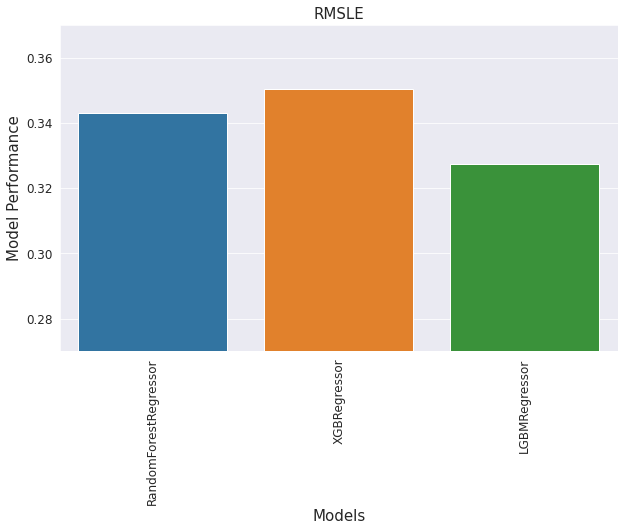

In [131]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.27, 0.37)
plt.title('RMSLE', fontsize=15)
plt.show()

### 가장 성능이 높은 LGBM의 하이퍼파라미터 튜닝수행

In [88]:
cut = int(len(train_X)*0.8)
h_train = train_X[:cut]
h_valid = train_X[cut:]

# 결측치 채우기
h_train_X = pd.DataFrame(imputer.transform(h_train), columns = h_train.columns)
h_valid_X = pd.DataFrame(imputer.transform(h_valid), columns = h_valid.columns)

h_train_y = train_y[:cut]
h_valid_y = train_y[cut:]
print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)

(973242, 28) (973242,) (243311, 28) (243311,)


In [89]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(h_train_X, label=h_train_y)
    dtest = lgb.Dataset(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)
    rmse = RMSE(h_valid_y, lgb_model.predict(h_valid_X))
    return rmse
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2022-05-02 15:14:27,578] A new study created in memory with name: no-name-f74a3752-827a-4ba7-bce6-378f94c83e59
[I 2022-05-02 15:15:21,340] Trial 0 finished with value: 0.835840277005482 and parameters: {'max_depth': 13, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 1938, 'min_child_samples': 76, 'subsample': 0.6315909175774905}. Best is trial 0 with value: 0.835840277005482.
[I 2022-05-02 15:16:14,910] Trial 1 finished with value: 0.8356101811551198 and parameters: {'max_depth': 5, 'learning_rate': 1.5430400149097381e-07, 'n_estimators': 2306, 'min_child_samples': 21, 'subsample': 0.4337244827306443}. Best is trial 1 with value: 0.8356101811551198.
[I 2022-05-02 15:16:18,756] Trial 2 finished with value: 0.5329649867880782 and parameters: {'max_depth': 11, 'learning_rate': 0.005252427629146827, 'n_estimators': 111, 'min_child_samples': 54, 'subsample': 0.8422371309477078}. Best is trial 2 with value: 0.5329649867880782.
[I 2022-05-02 15:16:45,312] Trial 3 finished with va

[I 2022-05-02 15:30:31,598] Trial 28 finished with value: 0.3135189571917605 and parameters: {'max_depth': 11, 'learning_rate': 0.004145217470794168, 'n_estimators': 2091, 'min_child_samples': 17, 'subsample': 0.6670020976304624}. Best is trial 25 with value: 0.31243129793939056.
[I 2022-05-02 15:31:30,143] Trial 29 finished with value: 0.6965259862219703 and parameters: {'max_depth': 12, 'learning_rate': 9.849039909293815e-05, 'n_estimators': 2210, 'min_child_samples': 40, 'subsample': 0.6547649579440067}. Best is trial 25 with value: 0.31243129793939056.
[I 2022-05-02 15:32:25,950] Trial 30 finished with value: 0.44386197175342795 and parameters: {'max_depth': 11, 'learning_rate': 0.0004422604718832665, 'n_estimators': 2029, 'min_child_samples': 28, 'subsample': 0.5103711596314336}. Best is trial 25 with value: 0.31243129793939056.
[I 2022-05-02 15:32:54,090] Trial 31 finished with value: 0.3134008424856445 and parameters: {'max_depth': 7, 'learning_rate': 0.0030372210258869277, 'n_e

[I 2022-05-02 15:42:40,003] Trial 56 finished with value: 0.367764703036091 and parameters: {'max_depth': 13, 'learning_rate': 0.0015863733944244808, 'n_estimators': 874, 'min_child_samples': 21, 'subsample': 0.5612163106975813}. Best is trial 42 with value: 0.31195323561793314.
[I 2022-05-02 15:43:11,604] Trial 57 finished with value: 0.4184305239566449 and parameters: {'max_depth': 9, 'learning_rate': 0.0007909112957842544, 'n_estimators': 1294, 'min_child_samples': 15, 'subsample': 0.7258115204260835}. Best is trial 42 with value: 0.31195323561793314.
[I 2022-05-02 15:43:39,595] Trial 58 finished with value: 0.5793933122065529 and parameters: {'max_depth': 12, 'learning_rate': 0.00040954509158038394, 'n_estimators': 1127, 'min_child_samples': 8, 'subsample': 0.6252200347531143}. Best is trial 42 with value: 0.31195323561793314.
[I 2022-05-02 15:44:04,522] Trial 59 finished with value: 0.3238588461123544 and parameters: {'max_depth': 8, 'learning_rate': 0.002072806435372845, 'n_estim

[I 2022-05-02 15:52:58,522] Trial 84 finished with value: 0.313710468228241 and parameters: {'max_depth': 11, 'learning_rate': 0.0017632139120389888, 'n_estimators': 1795, 'min_child_samples': 15, 'subsample': 0.8152393533112492}. Best is trial 78 with value: 0.3117565625832755.
[I 2022-05-02 15:53:32,259] Trial 85 finished with value: 0.3136561819083033 and parameters: {'max_depth': 11, 'learning_rate': 0.0026126090757698753, 'n_estimators': 2280, 'min_child_samples': 22, 'subsample': 0.7235079484872892}. Best is trial 78 with value: 0.3117565625832755.
[I 2022-05-02 15:54:19,654] Trial 86 finished with value: 0.3385227206377208 and parameters: {'max_depth': 12, 'learning_rate': 0.0010108330295504567, 'n_estimators': 1733, 'min_child_samples': 10, 'subsample': 0.7634401923000829}. Best is trial 78 with value: 0.3117565625832755.
[I 2022-05-02 15:55:29,663] Trial 87 finished with value: 0.8249279800450209 and parameters: {'max_depth': 10, 'learning_rate': 6.0682686023792965e-06, 'n_est

In [90]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.3117565625832755,
params {'max_depth': 10, 'learning_rate': 0.007608540500011125, 'n_estimators': 1455, 'min_child_samples': 16, 'subsample': 0.7021904838413824}


<BarContainer object of 28 artists>

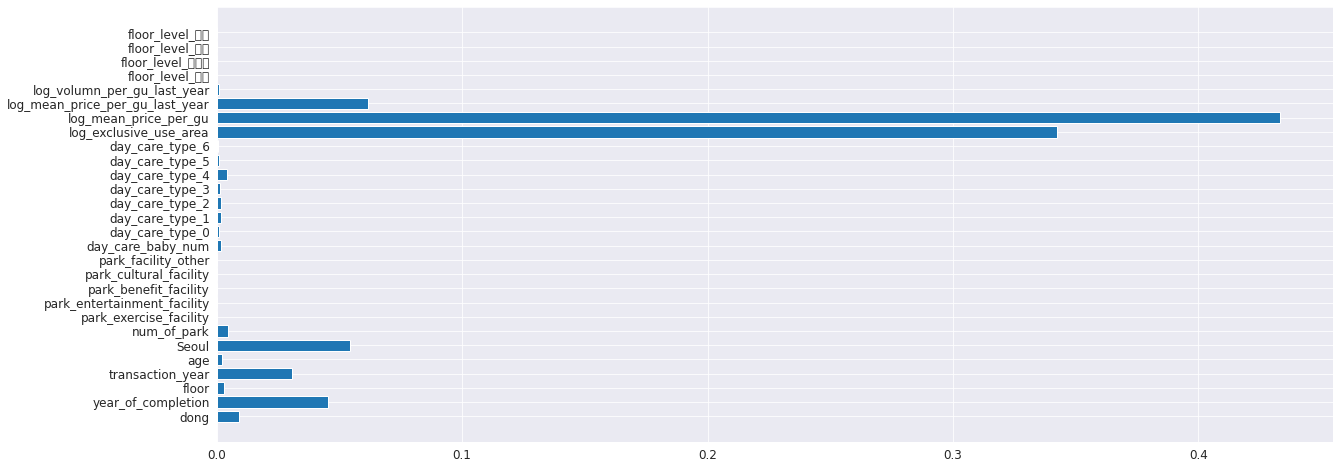

In [91]:
plt.barh(train_X.columns, rf.feature_importances_)

# 파이프라인 구축

In [92]:
train_X.columns

Index(['dong', 'year_of_completion', 'floor', 'transaction_year', 'age',
       'Seoul', 'num_of_park', 'park_exercise_facility',
       'park_entertainment_facility', 'park_benefit_facility',
       'park_cultural_facility', 'park_facility_other', 'day_care_baby_num',
       'day_care_type_0', 'day_care_type_1', 'day_care_type_2',
       'day_care_type_3', 'day_care_type_4', 'day_care_type_5',
       'day_care_type_6', 'log_exclusive_use_area', 'log_mean_price_per_gu',
       'log_mean_price_per_gu_last_year', 'log_volumn_per_gu_last_year',
       'floor_level_저층', 'floor_level_중저층', 'floor_level_중층',
       'floor_level_고층'],
      dtype='object')

In [118]:
def set_newdf(df, ref_df, model, mean_price_per_gu, price_per_gu_last_year, num_park_per_dong, num_facilty_per_dong, 
              aggregated_day_care_center_df, convert_floor_level, dummy_model, dong_le, numeric_cols):
    
    # 변수 변환 및 구정보가 있는 엑셀 데이터 병합
    df["dong"] = df["dong"].apply(lambda x: x.split()[0])
    df = pd.merge(df, ref_df, left_on = ["city", "dong"], right_on=["시도", "법정동"], how="left")
    df.drop(["시도", "법정동"], axis=1, inplace=True)
    df.rename(columns={"시군구":"sigungu"}, inplace=True)

    # 년월 데이터를 년도와 월로 분리
    df["transaction_year"] = df["transaction_year_month"].apply(lambda x: str(x)[:4]).astype(int)
    df["transaction_month"] = df["transaction_year_month"].apply(lambda x: str(x)[-2:]).astype(int)

    # 서울 0 부산 1
    df["Seoul"] = (df["city"]=="서울특별시").astype(int)
    
    df['age'] = 2018 - df['year_of_completion']
    
    # floor_level 변수 생성
    df['floor'] = df['floor'].astype(int)
    df['floor_level'] = df['floor'].apply(lambda x: convert_floor_level(x))
    

    ### 시세관련 변수 ###
    # 구별 평균 시세 변수 부착
    df = pd.merge(df, mean_price_per_gu, on = ["city", "sigungu"], how="left")

    # 구별 작년 시세 변수 부착
    df = pd.merge(df, price_per_gu_last_year, on = ["city", "sigungu", "transaction_year"], how="left") # 작년 기록이 없을 경우 원본 보존
    df["volumn_per_gu_last_year"].fillna(0, inplace=True)    # 거래량이 없을 경우 0


    ### 공원 데이터 ###
    df = pd.merge(df, num_park_per_dong, left_on = ['city', 'sigungu', 'dong'], right_on = ['city', 'gu', 'dong'], how = 'left')
    df['num_of_park'].fillna(0, inplace = True)
    df.drop('gu', axis = 1, inplace = True)
    
    df = pd.merge(df, num_facilty_per_dong, left_on = ['city', 'sigungu', 'dong'], right_on = ['city', 'gu', 'dong'], how = 'left')
    df[facility_cols].fillna(0, inplace = True)
    df.drop('gu', axis = 1, inplace = True)

    ### 어린이집 데이터 ###
    df = pd.merge(df, aggregated_day_care_center_df, left_on = ['city', 'sigungu'], right_on = ['city', 'gu'], how = 'left')
    df[aggregated_day_care_center_df.columns].fillna(0, inplace = True)
    df.drop('gu', axis = 1, inplace = True)
    
    df["dong"] = dong_le.transform(df["dong"])

    ### 로그변환
    for col in numeric_cols[:-1]:
        df["log_"+col] = np.log1p(df[col])
        df["log_"+col] = np.log1p(df[col])

    ### 더미화
    for floor in dummy_model.encoder_dict_["floor_level"]:
        col_name = "floor_level" + "_" + floor
        df[col_name] = (df["floor_level"] == floor).astype(int)  
        
    # 필요없는 데이터 제거
    df = df.drop(['transaction_id', 'apartment_id', 'city', 'jibun', 'apt', 'sigungu', 'transaction_year_month', 'transaction_month', 'transaction_date', 'sigungu',
                 'addr_kr', 'exclusive_use_area', 'mean_price_per_gu',  'mean_price_per_gu_last_year',  'volumn_per_gu_last_year', "floor_level"], axis = 1) 
       
    df = pd.DataFrame(imputer.transform(df), columns = df.columns)

    return df

In [119]:
test_df = pd.read_csv("test.csv")
test_df = set_newdf(test_df, ref_df, model, mean_price_per_gu, price_per_gu_last_year, num_park_per_dong,
                    num_facilty_per_dong, aggregated_day_care_center_df, convert_floor_level, dummy_model, dong_le, numeric_cols)

In [130]:
final_lgb_model = lgb.LGBMRegressor(**trial_params)
final_lgb_model.fit(train_X, train_y)
final_lgb_pred = final_lgb_model.predict(test_df)

final_pred_sub = np.expm1(final_lgb_pred)
final_pred_sub

array([27287.56597097, 14899.7037019 , 18611.83766925, ...,
       53669.46937155, 47716.87372817, 28799.3157823 ])

In [132]:
sample_sub = pd.read_csv("submission.csv")
sample_sub["transaction_real_price"] = final_pred_sub
sample_sub

,transaction_id,transaction_real_price
0,1145756,27287.565971
1,1198704,14899.703702
2,1222384,18611.837669
3,1179897,122498.583443
4,1223091,47545.247190
...,...,...
5458,1174640,78687.529205
5459,1175575,128041.885931
5460,1157024,53669.469372
5461,1136863,47716.873728


In [133]:
sample_sub.to_csv("transaction_real_price_submit.csv", index=False)